### Import libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer

In [3]:
#define some constants
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [4]:
# using tensorflow to preprocess the dataset

dataset=tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
# finding out the 3 classes
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
#print first image
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    
# 2D array each number between 0,255    

[[[164. 161. 170.]
  [179. 176. 185.]
  [122. 119. 128.]
  ...
  [174. 173. 181.]
  [174. 173. 181.]
  [174. 173. 181.]]

 [[162. 159. 168.]
  [115. 112. 121.]
  [132. 129. 138.]
  ...
  [174. 173. 181.]
  [174. 173. 181.]
  [174. 173. 181.]]

 [[149. 146. 155.]
  [148. 145. 154.]
  [108. 105. 114.]
  ...
  [175. 174. 182.]
  [174. 173. 181.]
  [174. 173. 181.]]

 ...

 [[153. 149. 163.]
  [143. 139. 153.]
  [130. 126. 140.]
  ...
  [147. 149. 162.]
  [146. 148. 161.]
  [146. 148. 161.]]

 [[108. 104. 118.]
  [171. 167. 181.]
  [116. 112. 126.]
  ...
  [149. 151. 164.]
  [150. 152. 165.]
  [151. 153. 166.]]

 [[132. 128. 142.]
  [122. 118. 132.]
  [146. 142. 156.]
  ...
  [148. 150. 163.]
  [151. 153. 166.]
  [153. 155. 168.]]]


In [8]:
#print first image shape
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


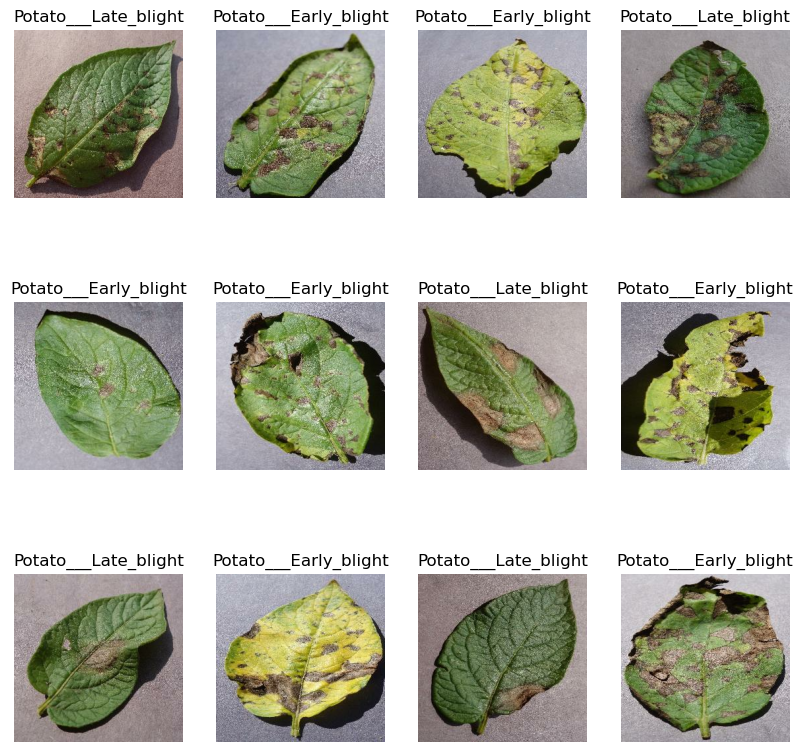

In [9]:
#visualization 
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range (12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### Split dataset into train ,validation and test

In [11]:
# 80% train , 10% validation , 10% test 

In [12]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,tes_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle :
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [13]:
train_ds ,val_ds ,test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

In [17]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Preprocessing

In [30]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [32]:
data_augmantation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

### Model 

In [34]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\Softlaptop\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.5049 - loss: 0.9165 - val_accuracy: 0.6302 - val_loss: 0.7592
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.6246 - loss: 0.7879 - val_accuracy: 0.7344 - val_loss: 0.6160
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7994 - loss: 0.4512 - val_accuracy: 0.8802 - val_loss: 0.3342
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8777 - loss: 0.3015 - val_accuracy: 0.8594 - val_loss: 0.3341
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9225 - loss: 0.2160 - val_accuracy: 0.8698 - val_loss: 0.2637
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9079 - loss: 0.2688 - val_accuracy: 0.9062 - val_loss: 0.2302
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9425 - loss: 0.1481 - val_accuracy: 0.9375 - val_loss: 0.1377
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9508 - loss: 0.1145 - val_accuracy: 0.9167 - v

In [43]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.9893 - loss: 0.0219


In [45]:
scores

[0.013160478323698044, 0.9921875]

### Plotting the accuracy

In [48]:
history

In [50]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [52]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [54]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8940722346305847,
 0.7267676591873169,
 0.4135821759700775,
 0.26421019434928894,
 0.1942334920167923]

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

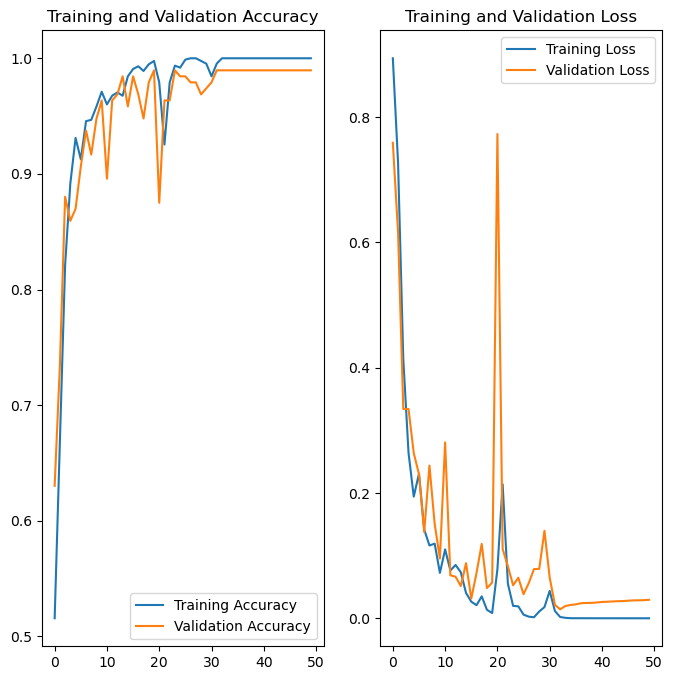

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run predictions

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


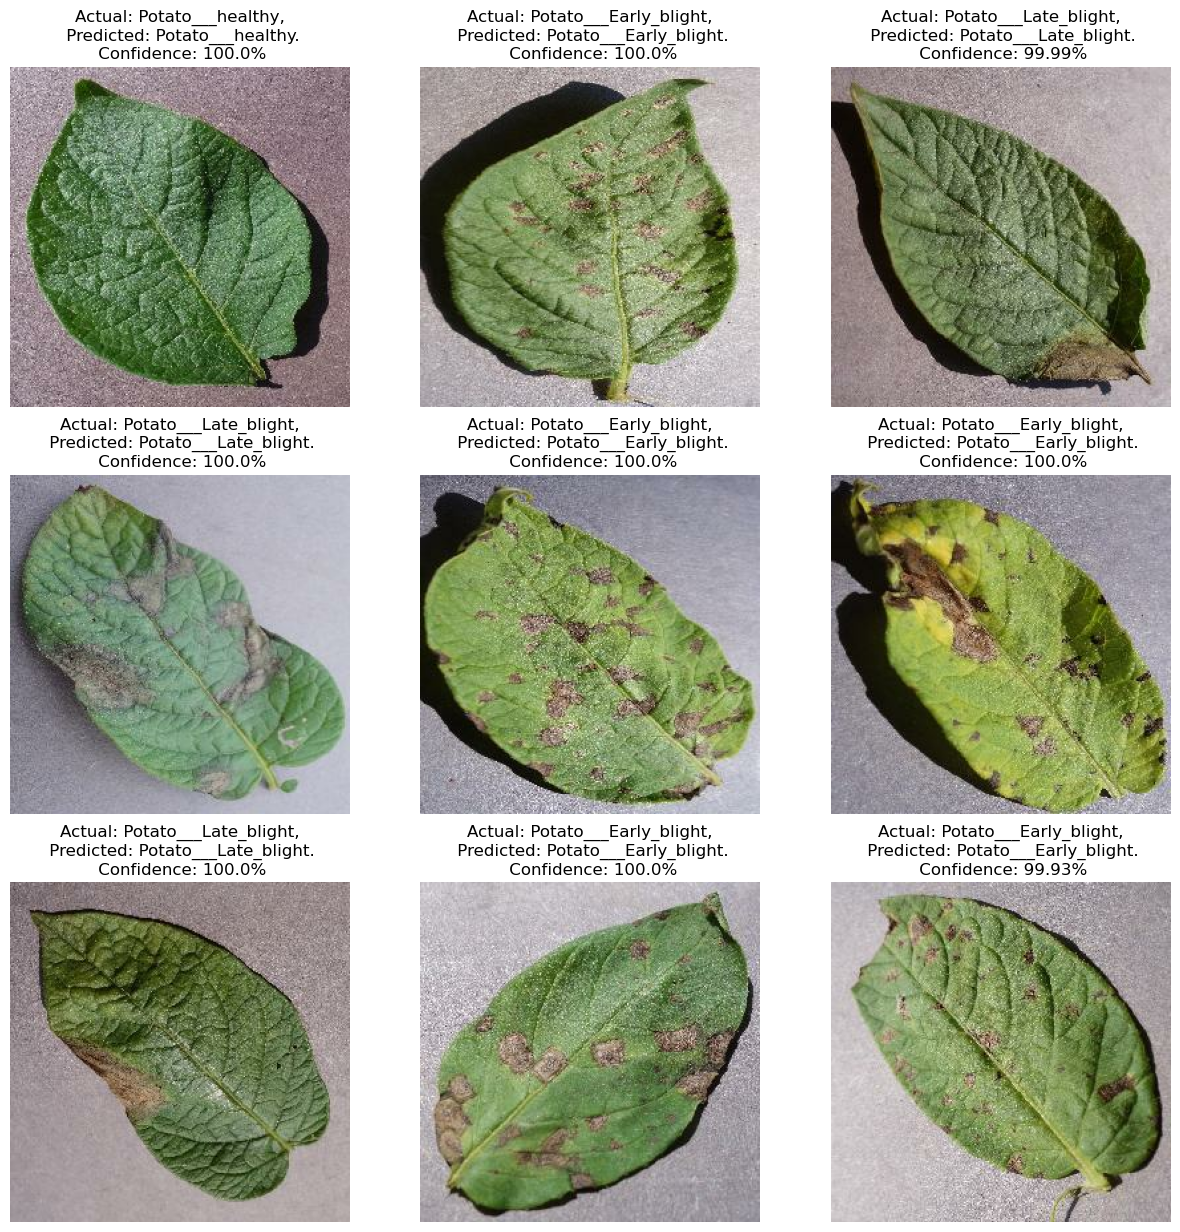

In [65]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving model

In [69]:
import os
model_version=1
model.save(f"../models/{model_version}.keras")

In [71]:
 model.save("../potatoes.h5")